کتابخانه های مورد نیازمان را به شرح ذیل فراخوانی کردیم 

In [2]:
import pandas as pd
import numpy as np
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_swiss_roll
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import random
from sklearn.model_selection import KFold
from statistics import mean 
random.seed(1)
import math


داده ها را فراخوانی کرده و 100 مورد از آن ها را برای بررسی سمپل گرفتیم

In [3]:
datax=pd.read_csv('X.dat', sep="  ", header=None)
datay=pd.read_csv('Y.dat', sep="  ", header=None)
datax[3]=datay
data=datax.sample(100)
Y=np.array(data[:][3])
X=np.array(data.drop([3], axis=1))

کار اضافی : توزیع داده ها را در سه بعد به نمایش گزاشتیم

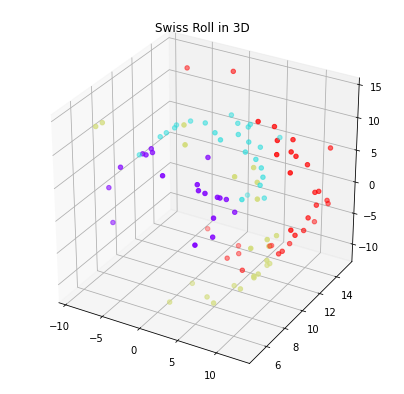

In [4]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap=plt.cm.rainbow)
plt.title('Swiss Roll in 3D')
plt.show()

کار اضافی : داده ها را با استفاده از روش زیر به دو بعد کاهش داده و در دو بعد به نمایش گزاشتیم که طبق شکل حرکت دورانی دارند و این نیز به ما ایده می دهد که توابع شعاعی میتوانند برای این مجموع دادگان موثر واقع شودند 
PCA

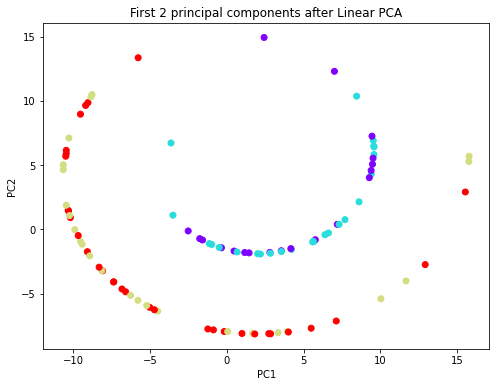

In [5]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[:, 0], X_spca[:, 1], c=Y, cmap=plt.cm.rainbow)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

توابع فاصله و خوشه بندی را به شرح ذیل تعریف کردیم که منابع این توابع در گزارش اصلی ذکر شده است

In [6]:
def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)


def kmeans(X, k, max_iters):
    random.seed(1)
    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    converged = False
    
    current_iter = 0

    while (not converged) and (current_iter < max_iters):

        cluster_list = [[] for i in range(len(centroids))]

        for x in X:  # Go through each data point
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)

        cluster_list = list((filter(None, cluster_list)))

        prev_centroids = centroids.copy()

        centroids = []

        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))

        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

        converged = (pattern == 0)

        current_iter += 1

        return np.array(centroids), [np.std(x) for x in cluster_list]

کلاس شبکه توابع شعاعی را بهش کل زیر تعریف کردیم لازم به ذکر است تغییراتی وسیعی در سورس کد منبع انجام دادیم که میتوان از آنها به اضافه کردن 5 تابع شعاعی ، تابع پردیکت و ... اشاره کرد .

In [7]:
class RBF:

    def __init__(self, X, y,rbftype, std_from_clusters=True):
        self.X = X
        self.y = y
        self.rtype=rbftype
        self.number_of_classes = 5
        self.k = 10
        self.std_from_clusters = False

    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def rbf(self, x, c, s):
        #print('you definded rbf type wrongly; we take default')
        distance = get_distance(x, c)
        return 1 / np.exp(-distance / s ** 2)

    def gaussian_rbf(self, x, c, s):
        distance = get_distance(x, c)
        return np.exp(-distance / s ** 2)
    
    def InvMultiquadric_rbf(self, x, c, s):
        distance = get_distance(x, c)
        return np.power(distance + s ** 2,-1/2)
    
    def Multiquadric_rbf(self, x, c, s):
        distance = get_distance(x, c)
        return np.power(distance + s ** 2,1/2)
   
    def linerspline_rbf(self, x, c, s):
        distance = get_distance(x, c)
        return np.sqrt(distance)
    
    def cubicspline_rbf(self, x, c, s):
        distance = np.sqrt(get_distance(x, c))
        return np.power(distance,3)
    
    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            if self.rtype=='gaussian':
                RBF_list.append([self.gaussian_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
            elif self.rtype=='InvMultiquadric':
                RBF_list.append([self.InvMultiquadric_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
            elif self.rtype=='Multiquadric':
                RBF_list.append([self.Multiquadric_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
            elif self.rtype=='linerspline':
                RBF_list.append([self.linerspline_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
            elif self.rtype=='cubicspline':
                RBF_list.append([self.cubicspline_rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
            else:
                RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)
    
    def fit(self):

        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters=1000)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)

        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, self.number_of_classes)
    
    def predict(self,tx):

        RBF_list_tst = self.rbf_list(tx, self.centroids, self.std_list)

        pred_ty = RBF_list_tst @ self.w

        pred_ty = np.array([np.argmax(x) for x in pred_ty])
        return(pred_ty)

در این بخش به ازای 5 تابع شعاعی تعریف شده را با 30 درصد داده تست و 70 درصد داده آموزش و جدا کردن داده ولیدیشن از داده آموزش با روش کراس ولیدیشن با 10 بخش مدل را آموزش داده و نتایج آن را ذخیره کرده و معیار های صحت سنجی را به نمایش گزاشتیم 

In [18]:
kf = KFold(n_splits=10)
rbf_type=['gaussian','InvMultiquadric','Multiquadric','linerspline','cubicspline']
ERR_test=[]
ERR_train=[]
ERR_valid=[]
for i in rbf_type:
    min =100
    cmin =100
    train_error=[]
    test_error=[]
    valid_error=[]
    X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=42)
    for train_index, valid_index in kf.split(X_train):
        X_train1, X_valid1= X_train[train_index], X_train[valid_index]  
        y_train1 = y_train[train_index]
        y_valid1 = y_train[valid_index]
        model = RBF(X_train1,y_train1,i)
        model.fit()
        y_valid_pred = model.predict(X_valid1)
        valid_error.append(1-accuracy_score(y_valid1 , y_valid_pred))            
        if 1-accuracy_score(y_valid1 , y_valid_pred)<min:
            min=1-accuracy_score(y_valid1 , y_valid_pred)
            best_model=model
    y_test_pred = best_model.predict(X_test) 
    test_error=1-accuracy_score(y_test,y_test_pred) 
    if test_error<cmin:
            cmin=test_error
            cbest_model=best_model
    y_test_pred = cbest_model.predict(X_test) 
    test_error=1-accuracy_score(y_test,y_test_pred)
    y_train_pred = cbest_model.predict(X_train) 
    train_error=1-accuracy_score(y_train,y_train_pred) 
    ERR_train.append(train_error)
    ERR_valid.append(mean(valid_error))
    ERR_test.append(test_error)
    print(i,':','\n',classification_report(y_test,y_test_pred),'\n')

gaussian : 
               precision    recall  f1-score   support

         1.0       1.00      0.75      0.86         8
         2.0       0.80      1.00      0.89         8
         3.0       0.50      1.00      0.67         4
         4.0       1.00      0.60      0.75        10

    accuracy                           0.80        30
   macro avg       0.82      0.84      0.79        30
weighted avg       0.88      0.80      0.80        30
 

InvMultiquadric : 
               precision    recall  f1-score   support

         1.0       1.00      0.50      0.67         8
         2.0       0.73      1.00      0.84         8
         3.0       0.50      1.00      0.67         4
         4.0       1.00      0.70      0.82        10

    accuracy                           0.77        30
   macro avg       0.81      0.80      0.75        30
weighted avg       0.86      0.77      0.77        30
 

Multiquadric : 
               precision    recall  f1-score   support

         1.0       1.

خطای آموزش ، اعتبار سنجی ، و آزمایش را بر حسب مدل های بدست آمده فوق به نمایش گزاشتیم 

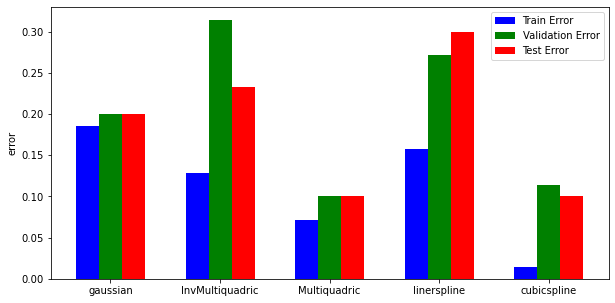

In [19]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.21       # the width of the bars

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

yvals = ERR_train
rects1 = ax.bar(ind, yvals, width, color='b')
zvals = ERR_valid
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = ERR_test
rects3 = ax.bar(ind+width*2, kvals, width, color='r')

ax.set_ylabel('error')
ax.set_xticks(ind+width)
ax.set_xticklabels( (rbf_type) )
ax.legend(('Train Error', 'Validation Error', 'Test Error'))

plt.show()

اینبار با استفاده از پنج تابع شعاعی تعریف شده و به ازای اندازه های مختلف داده آموزشی مدل را ساخته و معیار های ارزیابی را  بصورت مفصل به نمایش گزاشتیم  

In [29]:
#for saving result
a=np.zeros((5,7))
df=pd.DataFrame(a)
df

kf = KFold(n_splits=10)
train_error=[]
test_error=[]
valid_error=[]
ERR_test=[]
ERR_train=[]
ERR_valid=[]
counter=0
for j in [0.8,0.7,0.6,0.5,0.4,0.3,0.2]:
    acc=[]
    for i in rbf_type:
        min =100
        cmin =100
        X_train, X_test , y_train, y_test = train_test_split(X, Y, test_size=j,random_state=42)
        for train_index, valid_index in kf.split(X_train):
            X_train1, X_valid1= X_train[train_index], X_train[valid_index]  
            y_train1 = y_train[train_index]
            y_valid1 = y_train[valid_index]
            model = RBF(X_train1,y_train1,i)
            model.fit()
            y_valid_pred = model.predict(X_valid1)
            valid_error.append(1-accuracy_score(y_valid1 , y_valid_pred))            
            if 1-accuracy_score(y_valid1 , y_valid_pred)<min:
                min=1-accuracy_score(y_valid1 , y_valid_pred)
                best_model=model
        y_test_pred = best_model.predict(X_test) 
        test_error=1-accuracy_score(y_test,y_test_pred) 
        if test_error<cmin:
                cmin=test_error
                cbest_model=best_model
        y_test_pred = cbest_model.predict(X_test) 
        test_error=1-accuracy_score(y_test,y_test_pred)
        y_train_pred = cbest_model.predict(X_train) 
        train_error=1-accuracy_score(y_train,y_train_pred) 
        ERR_train.append(train_error)
        ERR_valid.append(mean(valid_error))
        ERR_test.append(test_error)
        acc.append(accuracy_score(y_test,y_test_pred))
        print(i,':    train size=',round(1-j,5),'\n',classification_report(y_test,y_test_pred),'\n')
    df[counter]=acc
    counter=counter+1
df=df.rename(index={0:'gaussian',1:'InvMultiquadric',2:'Multiquadric',3:'linerspline',4:'cubicspline'})
df=df.rename(columns={0: "20%",1:"30%",2:"40%",3:"50%",4:"60%",5:"70%",6:"80%"})

gaussian :    train size= 0.2 
               precision    recall  f1-score   support

         1.0       0.90      0.53      0.67        17
         2.0       0.36      0.22      0.27        23
         3.0       0.71      0.67      0.69        15
         4.0       0.50      0.84      0.63        25

    accuracy                           0.56        80
   macro avg       0.62      0.56      0.56        80
weighted avg       0.58      0.56      0.54        80
 

InvMultiquadric :    train size= 0.2 
               precision    recall  f1-score   support

         1.0       0.43      0.18      0.25        17
         2.0       0.33      0.13      0.19        23
         3.0       0.43      0.67      0.53        15
         4.0       0.49      0.80      0.61        25

    accuracy                           0.45        80
   macro avg       0.42      0.44      0.39        80
weighted avg       0.42      0.45      0.40        80
 

Multiquadric :    train size= 0.2 
               preci

linerspline :    train size= 0.5 
               precision    recall  f1-score   support

         1.0       0.82      0.82      0.82        11
         2.0       0.93      0.93      0.93        14
         3.0       0.64      0.70      0.67        10
         4.0       0.86      0.80      0.83        15

    accuracy                           0.82        50
   macro avg       0.81      0.81      0.81        50
weighted avg       0.82      0.82      0.82        50
 

cubicspline :    train size= 0.5 
               precision    recall  f1-score   support

         1.0       1.00      0.73      0.84        11
         2.0       0.93      1.00      0.97        14
         3.0       0.75      0.90      0.82        10
         4.0       0.93      0.93      0.93        15

    accuracy                           0.90        50
   macro avg       0.90      0.89      0.89        50
weighted avg       0.91      0.90      0.90        50
 

gaussian :    train size= 0.6 
               precision 

به علت حجیم بودن معیار های ارزیابی فوق و راحتی کار معیار صحت هر تابع شعاعی را به ازای اندازه داده های مختلف در جدول آماده کردیم   

In [30]:
print ("accuracy for all functions with diffrent size of Train data")
df

accuracy for all functions with diffrent size of Train data


,20%,30%,40%,50%,60%,70%,80%
gaussian,0.5625,0.828571,0.766667,0.90,0.750,0.866667,0.80
InvMultiquadric,0.4500,0.614286,0.800000,0.88,0.900,0.900000,0.90
Multiquadric,0.5875,0.657143,0.783333,0.86,0.800,0.866667,0.80
linerspline,0.5250,0.657143,0.750000,0.82,0.775,0.866667,0.85
cubicspline,0.6250,0.785714,0.866667,0.90,0.875,0.933333,0.90


خطای آموزش ، اعتبار سنجی ، و آزمایش را بر حسب مدل های بدست آمده فوق در اندازه داده های مختلف برای هر تابع شعاعی  به نمایش گزاشتیم 

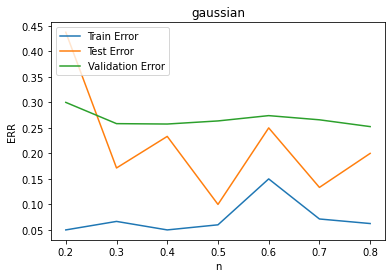

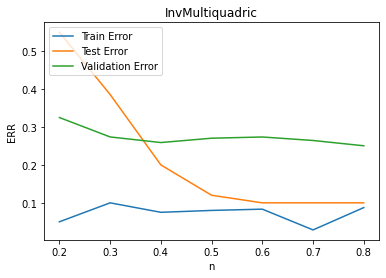

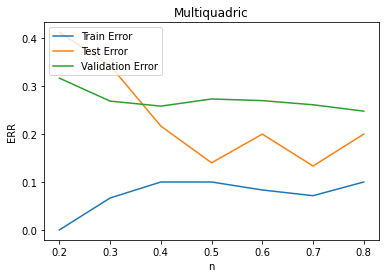

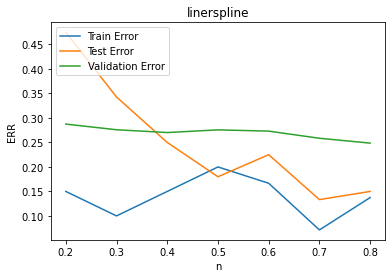

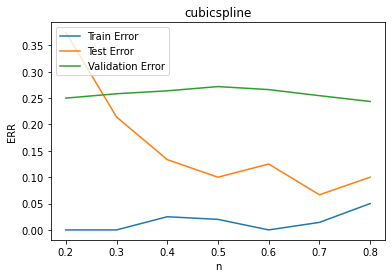

In [31]:
n=[0.2,0.3,0.4,0.5,0.6,0.7,0.8]
ptrain=np.zeros((5,7))
pvalid=np.zeros((5,7))
ptest=np.zeros((5,7))
k=0
for j in range(7):
    for i in range(5):
        ptrain[i][j]=ERR_train[k]
        k=k+1
k=0
for j in range(7):
    for i in range(5):
        pvalid[i][j]=ERR_valid[k]
        k=k+1
k=0
for j in range(7):
    for i in range(5):
        ptest[i][j]=ERR_test[k]
        k=k+1
plt.title("gaussian")
plt.plot(n,ptrain[0],label='Train Error')
plt.plot(n,ptest[0],label='Test Error')
plt.plot(n,pvalid[0],label='Validation Error')
plt.ylabel('ERR')
plt.xlabel('n')
plt.legend(loc='upper left')
plt.show()
plt.title("InvMultiquadric")
plt.plot(n,ptrain[1],label='Train Error')
plt.plot(n,ptest[1],label='Test Error')
plt.plot(n,pvalid[1],label='Validation Error')
plt.ylabel('ERR')
plt.xlabel('n')
plt.legend(loc='upper left')
plt.show()
plt.title("Multiquadric")
plt.plot(n,ptrain[2],label='Train Error')
plt.plot(n,ptest[2],label='Test Error')
plt.plot(n,pvalid[2],label='Validation Error')
plt.ylabel('ERR')
plt.xlabel('n')
plt.legend(loc='upper left')
plt.show()
plt.title("linerspline")
plt.plot(n,ptrain[3],label='Train Error')
plt.plot(n,ptest[3],label='Test Error')
plt.plot(n,pvalid[3],label='Validation Error')
plt.ylabel('ERR')
plt.xlabel('n')
plt.legend(loc='upper left')
plt.show()
plt.title("cubicspline")
plt.plot(n,ptrain[4],label='Train Error')
plt.plot(n,ptest[4],label='Test Error')
plt.plot(n,pvalid[4],label='Validation Error')
plt.ylabel('ERR')
plt.xlabel('n')
plt.legend(loc='upper left')
plt.show()